# Исследование для стартапа, который продаёт продукты питания.
**Нужно разобраться, как ведут себя пользователи нашего мобильного приложения.**

**Цель исследования:**


- Изучить воронку продаж. Узнаем, как пользователи доходят до покупки.\
Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах?\
На каких именно?
-После этого исследуем результаты A/A/B-эксперимента.\
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.
-Создание двух групп A вместо одной имеет определённые преимущества.\
Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

Для исследование мне был предоставн датасет **logs_exp.csv** — хранит логи пользователей о взаимосдействии с платформой.

Каждая запись в логе — это действие пользователя, или событие: 
- **EventName** — название события;
- **DeviceIDHash** — уникальный идентификатор пользователя;
- **EventTimestamp** — время события;
- **ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Откроем файл с данными и изучим общую информацию

Вносим необходимые бибилотеки

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats as st
import scipy.stats as stats
import warnings
import numpy as np
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
import datetime as dt
import math as mth
# — тире для себя

**Изучим датасет**

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv',sep='\t')
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [4]:
data.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

**Вывод: Датасет хороший, но надо немного поменять названия стобцов и сменить формат даты, а так же добавить отдельный столбец только с датой**

## Подготовка данных

**Переименую столбцы в удобные**

In [5]:
data = data.rename(columns= {'EventName': 'event_name', 'DeviceIDHash': 'user_id', 'EventTimestamp': 'event_time','ExpId': 'group' })

**Поменяю формат времени и добавлю новый столбец только с датой**

In [6]:
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data['event_date'] = data['event_time'].astype('datetime64[D]')

In [7]:
data.head(10)

,event_name,user_id,event_time,group,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26


In [8]:
data.duplicated().sum()

413

In [9]:
datd = data.drop_duplicates(inplace=True)

In [10]:
data.duplicated().sum()

0

In [11]:
data.groupby('group').agg({'user_id': 'nunique'}).sum()[0]

7551

In [12]:
data['user_id'].nunique()

7551

**Вывод: Конечный результат меня устраивает**

## Изучим и проверьте данные

### Сколько всего событий в логе?

In [13]:
print('Всего событий:', data['event_name'].count())

Всего событий: 243713


In [14]:
print('Уникальных событий:', data['event_name'].nunique())

Уникальных событий: 5


**Вывод: Всего 244 126 событий и 5 уникальных**

### Сколько всего пользователей в логе?

In [15]:
print('Уникальных пользователей:',data['user_id'].nunique())

Уникальных пользователей: 7551


**Вывод: Всего 7551 пользователей**

### Сколько в среднем событий приходится на пользователя?

In [16]:
round(data['user_id'].value_counts().mean())

32

In [17]:
round(data['user_id'].value_counts().median()) #медианное значение, значительно меньше

20

**Вывод: В среднем на одного пользователя приходится 32 события**

### Найти максимальную и минимальную дату, проверить данными за какой период я обладаю

In [18]:
data['event_date'].max()

Timestamp('2019-08-07 00:00:00')

In [19]:
data['event_date'].min()

Timestamp('2019-07-25 00:00:00')

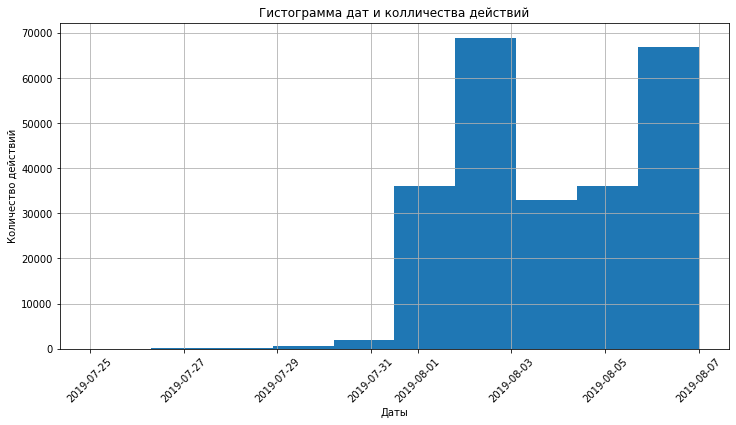

In [20]:
plt.figure(figsize=(12,6))
data['event_date'].hist()
plt.title('Гистограмма дат и колличества действий')
plt.ylabel('Количество действий')
plt.xlabel('Даты')
plt.xticks(rotation=45)
plt.show()

**Вывод: Я располагаю данными с 25 июля по 7 августа 2019 года, по графику мы видим, что большинство данных есть только в промежутке с 1 августа, их мы и возьмём**

In [21]:
data_new = data[data['event_date']>='2019-08-01']
round(((data_new['event_date'].count()/data['event_date'].count()*100)-100), 2)

-1.16

In [22]:
round(((data_new['user_id'].nunique()/data['user_id'].nunique()*100)-100), 2)

-0.23

In [23]:
print('Колличество пользователей после фильтрации:', data_new['user_id'].nunique())
print('Колличество уникальных пользователей сократилось на:',data['user_id'].nunique() - data_new['user_id'].nunique())

Колличество пользователей после фильтрации: 7534
Колличество уникальных пользователей сократилось на: 17


In [24]:
print('Колличество событий сократилось на:',data['event_name'].count() - data_new['event_name'].count())

Колличество событий сократилось на: 2826


**Вывод: Мы потеряли лишь 1.16% данных и 0.23% уникальных пользователей, из них 17 пользователей и 2826 событий**

### Проверим есть ли у нас пользователи из всех трёх экспериментальных групп.

In [25]:
report = data_new.groupby('group').agg({'user_id': 'nunique'}).reset_index()
report.columns = ['Группа', 'Уникальные пользователи']
report

,Группа,Уникальные пользователи
0,246,2484
1,247,2513
2,248,2537


**Вывод: Да, пользователей достаточно**

## Изучим воронку событий

###  Какие события есть в логах, как часто они встречаются.

In [26]:
report2 = data_new.groupby('event_name').agg({'event_time': 'count'}).reset_index()
report2.columns = ['Название Ивента', 'Колличество событий']
report2.sort_values(by = 'Колличество событий', ascending = False)

,Название Ивента,Колличество событий
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


**Вывод: Чаще всего пользователи смотрели на Главный экран(ничего удивительного)**

### Cколько пользователей совершали каждое из этих событий.

In [27]:
report3 = (data_new.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)).reset_index() 
report3['users_share'] = round(report3['user_id']/data_new['user_id'].nunique(), 2)
report3.columns = ['Название Ивента', 'Колличество пользоватей совершивших его', "Доля в %"]
report3

,Название Ивента,Колличество пользоватей совершивших его,Доля в %
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


**Вывод: Очевидно, что большинство людей сначала побывали на Главном экране, и очень мало людей прошли туториал(обучение)**

### Предположим, в каком порядке происходят события.

**Согласно, результату выше, предположить последовательность можно просто соотнести колличество переходов(или взаимодействие).**\
**В итоге:**
 - **1  MainScreenAppear** — главный экран
 - **2  OffersScreenAppear** — экран товара(предложения)
 - **3  CartScreenAppear** — корзина
 - **4  PaymentScreenSuccessful** — покупки товара
 - **5  Tutorial** — обучение

**Вывод: Так как *Tutorial* имеет меньше всего переходов, его можно исключить, для более подробного анализа**

In [28]:
event_group = data_new[data_new['event_name'] != 'Tutorial'] #убрали Tutorial

In [29]:
event_group['event_name'].unique()

array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'], dtype=object)

### По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки. То есть для последовательности событий A → B → C.

In [30]:
report4 = (event_group.groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by = 'user_id', ascending = False)).reset_index() 
report4['users_share'] = round(report4['user_id']/event_group['user_id'].nunique(), 2)
report4.columns = ['Название Ивента', 'Колличество пользоватей совершивших его', "Доля в %"]
report4

,Название Ивента,Колличество пользоватей совершивших его,Доля в %
0,MainScreenAppear,7419,0.99
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47


**Так как последовательность совпадает, мы может воспользоватся кодом, который был ранее**

**Вывод: 99% пользователей посетили главную страницу, 61% побывали на станице товара, добавили в корзину 50% пользователей, а совершили покупку лишь 47% пользователей**

### На каком шаге теряете больше всего пользователей?

**Согласно таблице выше, больше всего пользователей отваливаются на главной странице, не перейдя на страницу товара**

### Какая доля пользователей доходит от первого события до оплаты?

In [31]:
pay = event_group.loc[event_group['event_name'] == 'PaymentScreenSuccessful']['user_id']

In [32]:
report5 = event_group[event_group['user_id'].isin(pay)][['event_name', 'user_id']].groupby('event_name').nunique().sort_values(by ='user_id',ascending = False).reset_index()
report5['users_share'] = round(report5['user_id']/event_group['user_id'].nunique(), 2)
report5

,event_name,user_id,users_share
0,PaymentScreenSuccessful,3539,0.47
1,CartScreenAppear,3534,0.47
2,OffersScreenAppear,3532,0.47
3,MainScreenAppear,3441,0.46


**Вывод: Согласно таблице, только 47% пользователей походит до оплаты товара**

##  Изучим результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе

In [33]:
report6 = data_new.groupby('group').agg({'user_id': 'nunique'}).reset_index()
report6.columns = ['Группа', 'Уникальные пользователи']
report6

,Группа,Уникальные пользователи
0,246,2484
1,247,2513
2,248,2537


**В группах:**
- "246" - 2484 уникальных пользователей
- "247" - 2513 уникальных пользователей
- "248" - 2537 уникальных пользователей

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

**Так как у нас выборочные доли будут нормально распределены вокруг настоящей, воспользуемся методом norm**

Сформулируем гипотезы.\
***Нулевая:***  Статистически значимых различий в долях между группами нет.\
***Альтернативная:*** Статистически значимые различия в долях между группами есть.\
**alpha** = ***0.05***

In [34]:
#сделаем массив данных для группы 246
ex_group_246 = data_new.query('group == 246')
group_246 = ex_group_246.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
 
#сделаем массив данных для группы 247
ex_group_247 = data_new.query('group == 247')
group_247 = ex_group_247.groupby('event_name').agg({'user_id':'nunique'}).sort_values(by = 'user_id', ascending = False)
 
 
alpha = .05 # критический уровень статистической значимости
 
successes_246 = group_246.user_id[3]
trials_246 = group_246.user_id[0]
 
successes_247 = group_247.user_id[3]
trials_247 = group_247.user_id[0]
 
# пропорция успехов в первой группе:
p1_246 = successes_246/trials_246
 
# пропорция успехов во второй группе:
p2_247 = successes_247/trials_247
 
# пропорция успехов в комбинированном датасете:
p_combined = (successes_246 + successes_247) / (trials_246 + trials_247)
 
# разница пропорций в датасетах
difference = p1_246 - p2_247 
 
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_246 + 1/trials_247))
 
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  
 
p_value = (1 - distr.cdf(abs(z_value))) * 2
 
print('p-значение: ', p_value)
 
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть  разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, между долями разницы нет'
    ) 

p-значение:  0.12044299485641763
Не получилось отвергнуть нулевую гипотезу, между долями разницы нет


**Вывод: Статистически значимых различий между контрольными группами 246 и 247 — нет**

### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?

#### Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие.

In [35]:
us_groups = event_group.groupby('group')['user_id'].nunique()
us_groups['a_a'] = us_groups[246] + us_groups[247]
us_groups

group
246    2483
247    2512
248    2535
a_a    4995
Name: user_id, dtype: int64

In [36]:
group = event_group.pivot_table(index='event_name', values='user_id', columns='group', margins=True, aggfunc='nunique').sort_values(248, ascending = False).reset_index()
group.head()

group,event_name,246,247,248,All
0,All,2483,2512,2535,7530
1,MainScreenAppear,2450,2476,2493,7419
2,OffersScreenAppear,1542,1520,1531,4593
3,CartScreenAppear,1266,1238,1230,3734
4,PaymentScreenSuccessful,1200,1158,1181,3539


In [37]:
group['a_a'] = group[246] + group[247] #Комбинированная А/А группа
group = group.drop(columns='All')
group = group.set_index('event_name')
group

group,246,247,248,a_a
event_name,,,,
All,2483,2512,2535,4995
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [38]:
group['share_246'] = round((group[246] / group[246][0]*100), 2)
group['share_247'] = round((group[247] / group[247][0]*100), 2)
group['share_248'] = round((group[248] / group[248][0]*100), 2)
group['share_a_a'] = round((group['a_a'] / group['a_a'][0]*100), 2)
group

group,246,247,248,a_a,share_246,share_247,share_248,share_a_a
event_name,,,,,,,,
All,2483,2512,2535,4995,100.00,100.00,100.00,100.00
MainScreenAppear,2450,2476,2493,4926,98.67,98.57,98.34,98.62
OffersScreenAppear,1542,1520,1531,3062,62.10,60.51,60.39,61.30
CartScreenAppear,1266,1238,1230,2504,50.99,49.28,48.52,50.13
PaymentScreenSuccessful,1200,1158,1181,2358,48.33,46.10,46.59,47.21


**Вывод: Итого, мы получаем - самое популярное событие по группам это MainScreenAppear(главный экран), доли по группам:**
 - 246 — 98.67%
 - 247 — 98.57%
 - 248 — 98.34%
 - А/А — 98.62%

#### Проверим, будет ли отличие между группами статистически достоверным. Проделаем то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?

**Напишем функцию для проведения Z теста**

Сформулируем гипотезы(Работает на все последующие тесты).\
***Нулевая:***  Статистически значимых различий в долях между группами нет.\
***Альтернативная:*** Статистически значимые различия в долях между группами есть.\
**alpha** = ***0.05***

In [39]:
group = event_group.pivot_table(index='event_name', values='user_id', columns='group', aggfunc='nunique').sort_values(248, ascending = False)
group['a_a'] = group[246] + group[247]
group.head()

group,246,247,248,a_a
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [40]:
def z_test(group1, group2, alpha):
    
    for i in group.index:
       
        # пропорция успехов в первой группе
        p1 = group[group1][i] / us_groups[group1]
        # пропорция успехов во второй группе:
        p2 = group[group2][i] / us_groups[group2]
        # пропорция успехов в комбинированном датасете
        p_combined = ((group[group1][i] + group[group2][i]) / (us_groups[group1] + us_groups[group2]))
        
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/us_groups[group1] + 1/us_groups[group2]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        
        print('Группы {} и {}.Событие — {}. P-значение — {:.2f}. Уровень значимости — {}'.format(group1, group2, i, p_value, alpha))
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [41]:
z_test(246, 247, 0.05)

Группы 246 и 247.Событие — MainScreenAppear. P-значение — 0.75. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы 246 и 247.Событие — OffersScreenAppear. P-значение — 0.25. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы 246 и 247.Событие — CartScreenAppear. P-значение — 0.23. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы 246 и 247.Событие — PaymentScreenSuccessful. P-значение — 0.11. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод: при сравнении двух А/А групп мы наблюдаем - отсутствие различия ключевых метрик между группами, которые видят абсолютно одинаковые версии продукта. Соответсвенно, разбиение на группы работает корректно.**

#### Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.

In [42]:
z_test(246, 248, 0.05)

Группы 246 и 248.Событие — MainScreenAppear. P-значение — 0.34. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы 246 и 248.Событие — OffersScreenAppear. P-значение — 0.21. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы 246 и 248.Событие — CartScreenAppear. P-значение — 0.08. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы 246 и 248.Событие — PaymentScreenSuccessful. P-значение — 0.22. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [43]:
z_test(247, 248, 0.05)

Группы 247 и 248.Событие — MainScreenAppear. P-значение — 0.52. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы 247 и 248.Событие — OffersScreenAppear. P-значение — 0.93. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы 247 и 248.Событие — CartScreenAppear. P-значение — 0.59. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы 247 и 248.Событие — PaymentScreenSuccessful. P-значение — 0.73. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [44]:
z_test("a_a", 248, 0.05)

Группы a_a и 248.Событие — MainScreenAppear. P-значение — 0.35. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы a_a и 248.Событие — OffersScreenAppear. P-значение — 0.45. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы a_a и 248.Событие — CartScreenAppear. P-значение — 0.19. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы a_a и 248.Событие — PaymentScreenSuccessful. P-значение — 0.61. Уровень значимости — 0.05
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Вывод:**
- Нет оснований считать группы 246-248 теста разными.
- Нет оснований считать группы 247-248 теста разными.
- Нет оснований считать группы А/А-248 теста разными. 

In [45]:
def zz_test(group1, group2, alpha):
    
    for i in group.index:
       
        # пропорция успехов в первой группе
        p1 = group[group1][i] / us_groups[group1]
        # пропорция успехов во второй группе:
        p2 = group[group2][i] / us_groups[group2]
        # пропорция успехов в комбинированном датасете
        p_combined = ((group[group1][i] + group[group2][i]) / (us_groups[group1] + us_groups[group2]))
        
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/us_groups[group1] + 1/us_groups[group2]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        bonferroni_alpha = alpha / 16
        
        print ('p_value —', round(p_value, 2), 'с поправкой Бонферрони {}, событие — {}.'.format(bonferroni_alpha, i))
        if p_value < (bonferroni_alpha):
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
        

In [46]:
zz_test(246, 247, 0.05) #A/A тест

p_value — 0.75 с поправкой Бонферрони 0.003125, событие — MainScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.25 с поправкой Бонферрони 0.003125, событие — OffersScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.23 с поправкой Бонферрони 0.003125, событие — CartScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.11 с поправкой Бонферрони 0.003125, событие — PaymentScreenSuccessful.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [47]:
zz_test(246, 248, 0.05) 

p_value — 0.34 с поправкой Бонферрони 0.003125, событие — MainScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.21 с поправкой Бонферрони 0.003125, событие — OffersScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.08 с поправкой Бонферрони 0.003125, событие — CartScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.22 с поправкой Бонферрони 0.003125, событие — PaymentScreenSuccessful.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [48]:
zz_test(247, 248, 0.05)

p_value — 0.52 с поправкой Бонферрони 0.003125, событие — MainScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.93 с поправкой Бонферрони 0.003125, событие — OffersScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.59 с поправкой Бонферрони 0.003125, событие — CartScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.73 с поправкой Бонферрони 0.003125, событие — PaymentScreenSuccessful.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [49]:
zz_test("a_a", 248, 0.05)

p_value — 0.35 с поправкой Бонферрони 0.003125, событие — MainScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.45 с поправкой Бонферрони 0.003125, событие — OffersScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.19 с поправкой Бонферрони 0.003125, событие — CartScreenAppear.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p_value — 0.61 с поправкой Бонферрони 0.003125, событие — PaymentScreenSuccessful.
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Общие выводы теста :**
- Уровень статистической значимости для тестов мы использовали — 0,05 .
- Всего проверок сделано — 16 (4 АА и 12 АВ). Ни одна из проверок не показала, что есть разница между группами на всех этапах воронки.
- Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применена поправка Бонферрони (/16) для корректировки уровня альфа(alpha) для семейства статистических тестов для контроля вероятности совершения ошибки I рода.
- Даже без применения поправки уже понятны результаты, так как минимальный показатель без поправки P-значение -- 0.08( Группы 246 и 248.Событие -- CartScreenAppear).
- Если бы мы использовали уровень значимости равный 0,1 , единственный тест из 16 "Группы 246 и 248.Событие -- CartScreenAppear" попал бы под сомнение. Но применив поправку мы пришли бы к общим выводам.

## Общий вывод

Изучить воронку продаж. Узнаем, как пользователи доходят до покупки.
Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах?
На каких именно?

**Пользователи достоточно плохо доходят до покупки, всего лишь 47 процентов с момента посещения сайта, больше всего "застревают" на моменте выбора товара(возможно не подходит ассортимент)**

После этого исследуем результаты A/A/B-эксперимента.
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

**Так как целью проведения A/A/B-эксперимента была боязнь менеджеров о потере пользователей, эксперемент можно считать удачным, ведь значимых различий между группами обнаруженно не было**

Создание двух групп A вместо одной имеет определённые преимущества.
Если две контрольные группы окажутся равны, мы можем быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

**Как мы и сообщали ранее, при сравнении двух А/А групп мы наблюдаем - отсутствие различия ключевых метрик между группами, которые видят абсолютно одинаковые версии продукта. Соответсвенно, разбиение на группы работает корректно.**